# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии. 

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр. 

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии. 
 
 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Import библиотек

In [ ]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных на Google Drive

In [ ]:
uploaded = files.upload()

# Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [ ]:
df = pd.read_csv('/content/cars_moldova_cat_num.csv', delimiter = ',')
df

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

## Логистическая регрессия

Один из самых простых методов классификации — это логистическая регрессия. По существу, модель логистической регрессии представляет собой аналог линейной регрессии. Однако, если в случае линейной регрессии мы хотели провести линию через наши данные, то в случае логистической регрессии мы стремимся провести линию между двумя классами наших данных. Технически это сводится к тому, что введем функцию принятия решений для результата сопоставления наших данных и построенной линии.
Это можно описать как следующую модель:
$$ \hat{y}_i = \sigma \left(\sum_{j=0}^p w_jX_{ij}\right) \equiv \sigma \left(\sum_{j=1}^p w_jX_{ij}+b\right), $$
где <ul>
<li> $\sigma$ - функция принятия решений - функция активации;
<li> $ \hat{y}_i$ - результат принятия решений - класс экземпляра данных.
    </ul>
Из некоторых статистических выводов известно, что для такой модели необходимо выбрать функцию потерь следующего вида:
$$ L = -\frac{1}{n}\sum_{i=0}^{n-1}{y_i \log{\hat{y}_i}+(1-y_i)\log{(1-\hat{y}_i)}}$$

и следующий вид функции активации:
$$\sigma(z_i) = \frac{1}{1+\exp(-z_i)}, $$
где <ul>
    <li> $z_i = \sum_{j=0}^p w_jX_{ij} = X_iW^T$ ; 
     <li> тогда $\hat{y}_i =\sigma(X_iW^T) $.   </ul>
         
прежде чем записать выражение для градиента функции потерь запишем выражение для производной функции активации
$$ \sigma'(z_i) = \frac{\partial \sigma(z_i)}{\partial z_i} = (1-\sigma(z_i))\sigma(z_i) $$
Градиент функции потерь для одного элемента выборки может быть выражен следующим образом:
$$ 
\nabla_W L_i = 
-{
\left(\frac{y_i}{\sigma(X_iW^T)}-\frac{1-y_i}{1-\sigma(X_iW^T)}\right)\sigma'(X_iW^T)\odot X_i 
= -\left(y_i - \sigma(X_iW^T) \right)\odot X_i = -\left(y_i - \hat{y}_i\right)\odot X_i 
}
$$
Тогда правило обновления весовых параметров может быть записано как
$$ W^t = W^{t-1} - \eta\frac{1}{n}\sum_{i=0}^{n-1}\left(  \hat{y}_i -y_i\right )\odot X_i.$$
Отметим, что данное выражение эквиваленто записанному для логистической регрессии с точностью до коэффициента $2$, поэтому мы учтем данный параметр путем замены $\eta \to \eta/2$.
<br>





рассмотрим графики функции активации сигмоид и ее производной

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z)) 

In [ ]:
z = np.arange(-10,10,0.1)

plt.figure(figsize=(16,5))
plt.subplot(121); plt.plot(z,sigmoid(z)); plt.title('sigmoid')
plt.subplot(122); plt.plot(z,sigmoid_derivative(z)); plt.title('sigmoid derivative')
plt.show()

Как правило, после расчета функции активации мы должны округлить значения до 0 или до 1. То есть до значения метки одного из классов. Такое округление можно сделать по заданному порогу результатов функции активации. Например, мы можем сказать, что если значение сигмоида больше 0.5 то пусть будет класс 1, а если меньше, то наоборот. 

Однако, на практике иногда ставят высокий порог, 0.7 - 0.8. 

Запишем функцию определения класса.

Отметим, что в описанном смысле можно говорить о том, что результат сигмоида - это вероятность того, что аргумент функции (z) принадлежит одному из классов. Также отметим, что такой аргумент принято называть логит.



In [ ]:
def to_class(logit, threshold = 0.5):
    return (logit>=threshold)*1

In [ ]:
print( to_class(sigmoid(2.5), threshold = 0.7), ',',  to_class(sigmoid(-2.5), threshold = 0.7) )

Отметим, что для расчета функции потерь не следует пользоваться округлением до классов

Теперь рассмотрим функцию потерь. Отметим, что значениях логорифма мы ввели небольшую константу с целью исключить ошибку вида логорифм нуля.

In [ ]:
_EPS_ = 1e-6
def loss(yhat, y):
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

для начала рассмотрим значение функции активации для предельных случаев значений вероятности.

In [ ]:
print('неопределенность (yhat=0.5, y=1):\t %.3f'%loss(yhat=0.5, y=1))
print('неопределенность (yhat=0.5, y=0):\t %.3f'%loss(yhat=0.5, y=0))
print('уверенный 0 класс (yhat=0, y=0):\t %.3f'%loss(yhat=0.0, y=0))
print('уверенный 1 класс(yhat=1, y=1):\t %.3f'%loss(yhat=1, y=1))
print('ошибочный 0 класс (yhat=0, y=1):\t %.3f'%loss(yhat=0.0, y=1))
print('ошибочный 1 класс(yhat=1, y=0):\t %.3f'%loss(yhat=1, y=0))

Запишем все в один класс. Также добавим в функцию эластичную регуляризацию.

In [ ]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost,'-*')
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + self.l1_penalty + l2_term)

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #---------------------------------
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Запишим данные для классификации.

In [ ]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4
22446,0.64,0.479896,0.353333,0.046092,0.251134
22447,0.74,0.465893,0.479167,0.077144,0.331520
22448,0.70,0.572360,0.333333,0.058106,0.356492
22449,0.70,0.581916,0.375000,0.046593,0.362475
22450,0.24,0.579916,0.000000,0.008016,0.147012


Проведем тестирование без регуляризации 

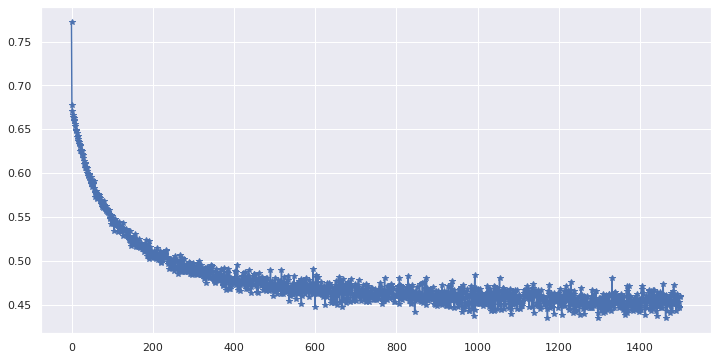

train Accuracy: 0.8040; test Accuracy: 0.8112
True Positives:3283	False Positives:730
False Negatives:1087	True Negatives:4523
Accuracy:0.8112
Recall:0.7513	Precision:0.8181
f1 measure:0.7833


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Посмотрим веса

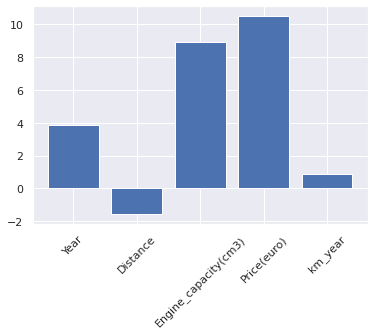

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с регуляризацией L2

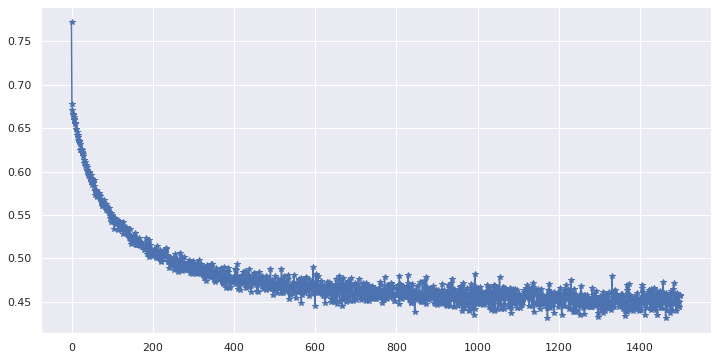

train Accuracy: 0.8044; test Accuracy: 0.8093
True Positives:3280	False Positives:745
False Negatives:1090	True Negatives:4508
Accuracy:0.8093
Recall:0.7506	Precision:0.8149
f1 measure:0.7814


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

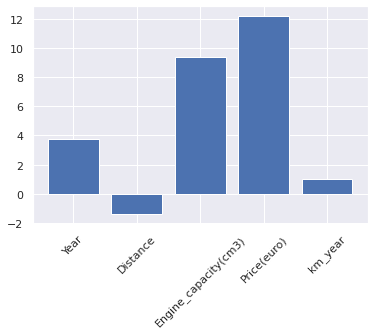

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с L1 регуляризацией

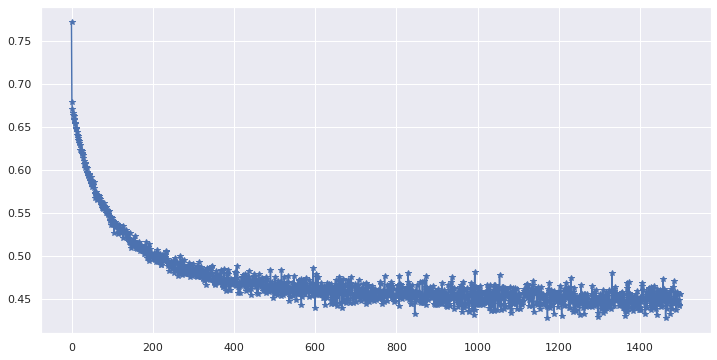

train Accuracy: 0.8058; test Accuracy: 0.8127
True Positives:3313	False Positives:745
False Negatives:1057	True Negatives:4508
Accuracy:0.8127
Recall:0.7581	Precision:0.8164
f1 measure:0.7862


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

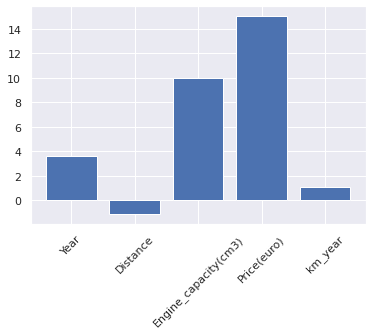

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Эластичная регрессия

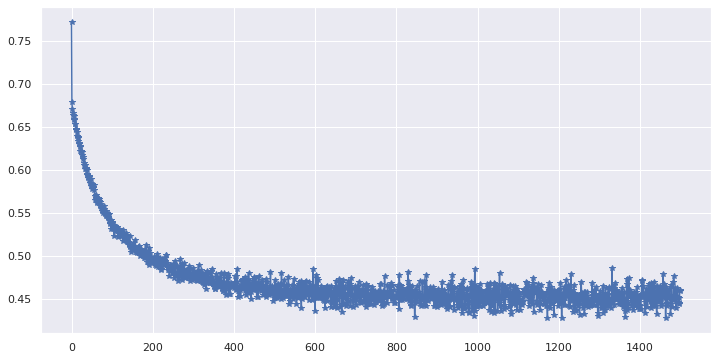

train Accuracy: 0.8056; test Accuracy: 0.8141
True Positives:3351	False Positives:770
False Negatives:1019	True Negatives:4483
Accuracy:0.8141
Recall:0.7668	Precision:0.8132
f1 measure:0.7893


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

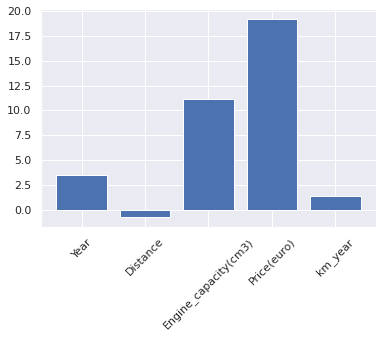

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Посмотрим, можно ли проводить классификацию без параметров связанных с расстоянием

In [ ]:
w, b = regr.get_w_and_b()

w[1] = 0
w[-1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=5000, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b)


print( 'train ACC: %.4f; test ACC: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

train ACC: 0.8068; test ACC: 0.8170
True Positives:3262	False Positives:653
False Negatives:1108	True Negatives:4600
Accuracy:0.8170
Recall:0.7465	Precision:0.8332
f1 measure:0.7874


# Контрольные вопросы